In [ ]:
from functools import partial
from typing import Callable

import arviz
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import pandas as pd
import seaborn as sns
from jax import Array
from numpyro import distributions as dist
from tqdm.notebook import tqdm

In [ ]:
@partial(jax.jit)
def unnormalized_log_p(x: Array) -> Array:
    return jnp.log(
        jnp.exp(-0.5 * (x**2))
        * (jnp.sin(x) ** 2 + 3 * jnp.cos(x) ** 2 * jnp.sin(7 * x) ** 2 + 1)
    )

In [ ]:
class PDensity(dist.Distribution):
    support = dist.constraints.interval(-3, 3)
    arg_constraints = {"start": support}

    def __init__(self, start: Array = jnp.zeros(1)):
        self.start = start
        super().__init__()

    def sample(self, key, sample_shape=()):
        return jnp.full(sample_shape, self.start)

    def log_prob(self, value):
        return unnormalized_log_p(value)

In [ ]:
def model():
    return numpyro.sample("x", PDensity())

In [ ]:
nuts_kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_samples=2000, num_chains=8, num_warmup=2000)
mcmc.run(jax.random.key(1))

In [ ]:
samples: Array = mcmc.get_samples()["x"]
sns.histplot(samples, binwidth=0.005)

In [ ]:
arv = arviz.from_numpyro(mcmc)
arviz.summary(arv)

In [ ]:
arviz.plot_posterior(arv)
plt.show()

In [ ]:
def mean_var_estimator(
    key: Array,
    est: Callable,
    batch_sizes: tuple[int, ...] = (10, 30, 100, 300, 1_000),
    estimator_calls: int = 200,
    **estimator_kwargs,
) -> pd.DataFrame:
    res = {}
    for batch_size in tqdm(batch_sizes, desc="Batch sizes"):
        batch_key, key = jax.random.split(key)
        batch_keys = jax.random.split(batch_key, estimator_calls)
        estimates = []
        for k in tqdm(batch_keys, unit="calls", leave=False):
            estimates.append(est(k, batch_size=batch_size, **estimator_kwargs))
        estimates = jnp.asarray(estimates)

        res[batch_size] = {
            "mean": jnp.nanmean(estimates).item(),
            "std": jnp.nanstd(estimates).item(),
        }

    return pd.DataFrame(res).T.reset_index(names="size")

In [ ]:
def mcmc_estimator(
    key: Array, fn: Callable, batch_size=2000, num_chains=10, num_warmup=500
) -> Array:
    m = numpyro.infer.MCMC(
        numpyro.infer.NUTS(model),
        num_warmup=num_warmup,
        num_samples=round(batch_size / num_chains),
        num_chains=num_chains,
    )
    m.run(key)
    return jnp.mean(fn(m.get_samples()["x"]))

In [ ]:
df = mean_var_estimator(
    key=jax.random.key(0),
    est=mcmc_estimator,
    fn=lambda x: x**2,
)
df

In [25]:
df.to_parquet("data/df_mcmc.pq")
df

,size,mean,std
0,10,0.905601,0.386866
1,30,0.930660,0.371498
2,100,0.913330,0.308413
3,300,0.941316,0.185273
4,1000,0.903769,0.110534


In [ ]:
df_rej_uniform = pd.read_parquet("data/df_rej_uniform.pq")
df_rej_gaussian = pd.read_parquet("data/df_rej_gaussian.pq")
df_import_gaussian = pd.read_parquet("data/df_import_gaussian.pq")

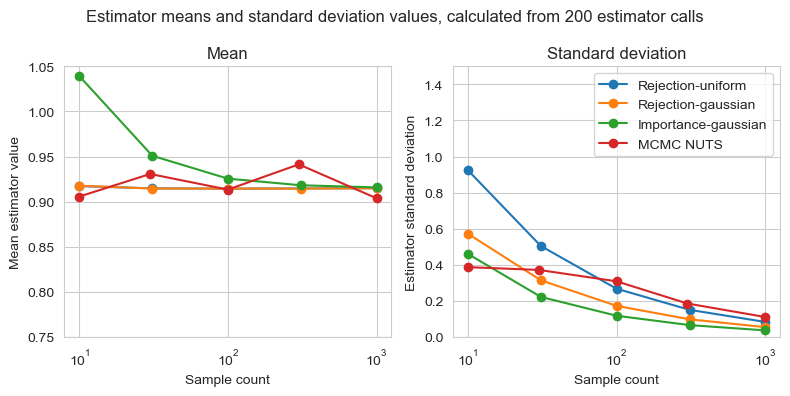

In [26]:
_, (ax_means, ax_stds) = plt.subplots(ncols=2, tight_layout=True, figsize=(8, 4))

for data, label in (
    (df_rej_uniform, "Rejection-uniform"),
    (df_rej_gaussian, "Rejection-gaussian"),
    (df_import_gaussian, "Importance-gaussian"),
    (df, "MCMC NUTS"),
):
    data.plot.line(
        x="size",
        y="mean",
        marker="o",
        ylim=(0.75, 1.05),
        ax=ax_means,
    )
    data.plot.line(
        x="size",
        y="std",
        marker="o",
        label=label,
        ylim=(0, 1.5),
        ax=ax_stds,
    )
plt.suptitle(
    "Estimator means and standard deviation values,"
    " calculated from 200 estimator calls"
)
ax_means.set(
    xscale="log",
    ylabel="Mean estimator value",
    title="Mean",
    xlabel="Sample count",
)
ax_stds.set(
    xscale="log",
    ylabel="Estimator standard deviation",
    title="Standard deviation",
    xlabel="Sample count",
)
ax_means.get_legend().remove()